# <img style="float: left; padding-right: 10px; width: 200px" src="https://raw.githubusercontent.com/trivikverma/researchgroup/master/assets/media/logo.png"> EPA-1316 Introduction to *Urban* Data Science 


## Assignment 2: Geographic Visualisation

**TU Delft**<br>
**Q1 2021**<br>
**Instructor:** Trivik Verma <br>
**TAs:**  Auriane Técourt, Luka Janssens, Marya El Malki, Mobeen Nawaz, Stephan Olde, Ruth Nelson, Juliana Gonçalves <br>
**[Centre for Urban Science & Policy]( https://cusp.tbm.tudelft.nl/)** <br>

**Done by:** Raquel Romão, student number 5629608


---



# ``Analysis``

I hypothesize that the neighbourhoods of The Hague with `higher average incomes` are more prone to `emit CO2`. Later, I also analysed if the bike lane length per neighbourhood could be related to it, hypotesizing that a bigger amount of `bike lanes` available could translate in a minor use of transportation by motorized vehicles and therefore a minor CO2 emission. For my analysis, I selected the year of 2016 (year available for the CO2 emissions parameter).

I used the following metrics:
 * Average personal income per resident [euros]
 * CO2 per neighbourhood per year (kton)
 * Bike lane length (km)

It was based on this that I proceeded with my analysis.

In [2]:
#Imports the necessary libraries
import os             
import pandas as pd
import numpy as np
import palettable as pltt
import seaborn as sns
import matplotlib.pyplot as plt
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

import osmnx as ox, geopandas as gpd
%matplotlib inline
ox.config(log_console=True, use_cache=True)

import matplotlib.style as style 
style.use('seaborn-colorblind') 

1. As it was suggested I used two datasets: merged 1 shapefile (already provided) and a csv file (that I found and obtained)

After looking up in [Den Haag Cijfers](https://denhaag.incijfers.nl/jive), I selected the variables I wanted to work with and downloaded the respective csv file.

In [3]:
#To load and read the dataset obtained from Den Haag Cijfers
d = 'data/NeighbourhoodsData.csv'

df = pd.read_csv(d, index_col=0)

In [4]:
df.head()

,CO2 per neighbourhood per year (kton)|2006,Average personal income per resident|2006
Buurten,,
01 Oud Scheveningen,3.6,18000
02 Vissershaven,3.0,19000
03 Scheveningen Badplaats,7.3,23400
04 Visserijbuurt,4.5,20400
05 v Stolkpark/Schev Bosjes,1.0,36600


In [5]:
#To load the provided shape file
shp_dir = 'data/neighborhoods.shp'

shp = gpd.read_file(shp_dir)

In [6]:
shp.head()

,neighb_cbs,neigb_cijf,geometry
0,Oostduinen,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ..."
1,Belgisch Park,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ..."
2,Westbroekpark,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ..."
3,Duttendel,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ..."
4,Nassaubuurt,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ..."


In [7]:
#To obtain the columns names
shp.columns

Index(['neighb_cbs', 'neigb_cijf', 'geometry'], dtype='object')

In [8]:
#To exclude the column relative to cbs dataset, since it is not the one used
shp = shp.drop('neighb_cbs', axis=1)
shp.head()

,neigb_cijf,geometry
0,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ..."
1,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ..."
2,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ..."
3,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ..."
4,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ..."


<AxesSubplot:>

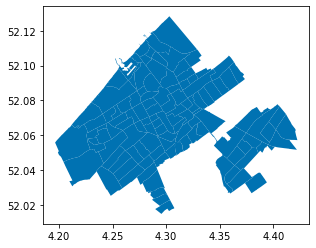

In [9]:
shp.plot()

In [10]:
#To merge the shapefile and the csv file, by neighbourhood
data = shp.join(df, on='neigb_cijf')
data.head()

,neigb_cijf,geometry,CO2 per neighbourhood per year (kton)|2006,Average personal income per resident|2006
0,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,-
1,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500
2,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400
3,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900
4,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300


2. Then, I cleaned my data and made it tabular.

In [11]:
#rename columns to more accessible names
data = data.rename(columns={'neigb_cijf': 'neigb'})
data = data.rename(columns={'CO2 per neighbourhood per year (kton)|2006': 'CO2'})
data = data.rename(columns={'Average personal income per resident|2006': 'income'})

After renaming the columns to more acessible names, I looked for missing values.

In [12]:
print(np.sum([data.neigb.isnull()]))
print(np.sum([data.geometry.isnull()]))
print(np.sum([data.CO2.isnull()]))
print(np.sum([data.income.isnull()]))

0
0
0
0


I came to the conclusion that the values that were not available in the dataset from Den Haag Cijfers were replaced with a '-', so taking this into account I tried to get a sense of how many missing values there are for each column.

In [14]:
#Missing values for each column
print(np.sum([data.neigb == '-']))
print(np.sum([data.geometry.isnull()]))
print(np.sum([data.CO2 == '-']))
print(np.sum([data.income == '-']))

0
0
4
8


To make it possible to manage them later, I opted to replace them for NaN's:

In [15]:
data = data.replace(['-'], np.nan)
data.head()

,neigb,geometry,CO2,income
0,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,NaN
1,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500
2,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400
3,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900
4,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300


Afterwards, I tried to get a sense of the df data types:

In [16]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   neigb     114 non-null    object  
 1   geometry  114 non-null    geometry
 2   CO2       110 non-null    object  
 3   income    106 non-null    object  
dtypes: geometry(1), object(3)
memory usage: 3.7+ KB


I converted the dtype of the `CO2` and `income` columns to numeric values, since I don't want to work with objects.

In [17]:
#Convert the object dtypes columns to numeric values
data[["CO2", "income"]] = data[["CO2", "income"]].apply(pd.to_numeric)
data.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   neigb     114 non-null    object  
 1   geometry  114 non-null    geometry
 2   CO2       110 non-null    float64 
 3   income    106 non-null    float64 
dtypes: float64(2), geometry(1), object(1)
memory usage: 3.7+ KB


Since I am working with so little cases and variables, I opted to keep all of them and replace the missing values with the respective column average.

In [18]:
#Replaces the missing values with the respective column average
for i in ['CO2', 'income']:  
    data[i].fillna(value=data[i].mean(),inplace=True)
    
data.head()

,neigb,geometry,CO2,income
0,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,22284.90566
1,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.00000
2,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400.00000
3,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900.00000
4,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300.00000


One of the rows belonging do the neigb column has its entrie as "Unknown" and since it doens't make sense to analise something unknow, I chose to remove this case from the data.

In [19]:
#To select only the cases not named 'Unknown'
data=data[data.neigb != 'Unknown']
data.head()

,neigb,geometry,CO2,income
0,70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,22284.90566
1,71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.00000
2,73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400.00000
3,74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900.00000
4,48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300.00000


In [20]:
#To set as index the neighbourhood's column
data=data.set_index('neigb')
data.head()

,geometry,CO2,income
neigb,,,
70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,22284.90566
71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.00000
73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400.00000
74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900.00000
48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300.00000


3. Afterwards, I carried out an exploratory data analysis (EDA).

First of all, to make the interpretation of the data more clear, I decided to divide the values of each variable in 4 groups, similarly to what appears in the Den Haag in Cijfers website: Lower, Average, Higher and Much Higher.

The range of values for each group are as follows (taking into account the mean in the cell below [obtained by the `describe()` function] and the website's values for each group):

* Lower Income  -  smaller or equal to `16000`;
* Average Income  - ` ]16000, 23000]`;
* Higher  -  `]23000, 29000]`;
* Much Higher  -  bigger than `29000`.

In [21]:
data.describe()

,CO2,income
count,114.000000,114.000000
mean,4.459091,22284.905660
std,3.073158,8366.344212
min,0.000000,9400.000000
25%,2.300000,15825.000000
50%,3.850000,21050.000000
75%,6.275000,25575.000000
max,14.200000,51000.000000


In [22]:
#To add a column with the income group in which each neighbourhood is included 
income_group = []
for row in data['income']:
    if row <= 16000 :    income_group.append('Lower')
    elif (row > 16000) & (row <= 23000):   income_group.append('Average')
    elif (row > 23000) & (row <= 29000):  income_group.append('Higher')
    elif row > 29000:  income_group.append('Much Higher')
            
data['income_group'] = income_group
data.head()

,geometry,CO2,income,income_group
neigb,,,,
70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,22284.90566,Average
71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.00000,Higher
73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400.00000,Much Higher
74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900.00000,Much Higher
48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300.00000,Much Higher


It was only then that I started graphing, taking into account the principals for graphic excellence (named below each plot).

#### Histograms

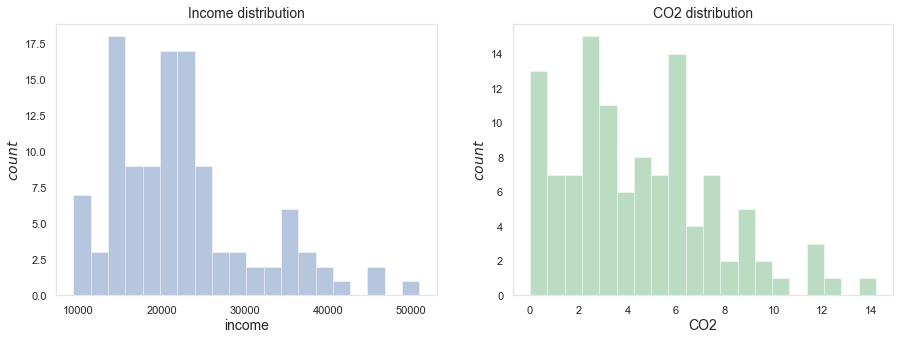

In [23]:
#To plot an histogram for each variable 
sns.set(color_codes=True)

fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.set(font_scale=0.5)

colors = ['b','g']
title = ['Income distribution', 'CO2 distribution']
variables = ['income', 'CO2']

#To plot each variable and personalize the histogram
for i in range(len(variables)):
    sns.distplot(data[variables[i]], kde=False, bins=20, ax=ax[i], color=colors[i]);
    ax[i].set_title(title[i], fontsize=14)
    ax[i].set_xlabel(variables[i], fontsize=14)
    ax[i].set_ylabel(r'$count$', fontsize=14)
    ax[i].grid(False)
    ax[i].set_facecolor('w')
    ax[i].spines['bottom'].set_color('0.9')
    ax[i].spines['left'].set_color('0.9')
    ax[i].spines['top'].set_color('0.9')
    ax[i].spines['right'].set_color('0.9')




For this figure I used the following principals for graphic excellence:

 * Encourage the eye to compare different pieces of data.
 * Present data in a way to facilitate comparisons.
 * Make efficient use of space.

Then, I tried to include the `income_groups` variable in a histogram.

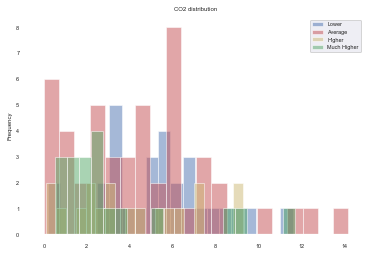

In [24]:
#To group the data by income group
x1 = data.loc[data.income_group == 'Lower', 'CO2']
x2 = data.loc[data.income_group == 'Average', 'CO2']
x3 = data.loc[data.income_group == 'Higher', 'CO2' ]
x4 = data.loc[data.income_group == 'Much Higher', 'CO2']
lx =[x1,x2,x3,x4]

#To plot the data respective to each income group
plt.hist(x1, alpha=0.5, bins=20, color='b', edgecolor='w', linewidth=1, label='Lower')
plt.hist(x2, alpha=0.5, bins=20, color='r', edgecolor='w', linewidth=1, label='Average')
plt.hist(x3, alpha=0.5, bins=20, color='y', edgecolor='w', linewidth=1, label='Higher')
plt.hist(x4, alpha=0.5, bins=20, color='g', edgecolor='w', linewidth=1, label='Much Higher')
plt.gca().set(title='CO2 distribution', ylabel='Frequency', facecolor='w')

plt.legend();

This was not the histogram I was planning to obtain. I was not happy about it, since it is not easy to interpret. That is why I choose to create the following subplot and break apart each group in different plots .

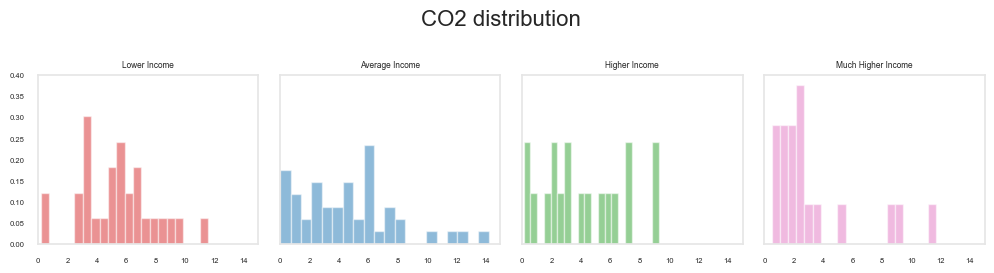

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)

colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink'] 
group_title = ['Lower Income', 'Average Income', 'Higher Income', 'Much Higher Income']

#To group the data by income group
x1 = data.loc[data.income_group == 'Lower', 'CO2']
x2 = data.loc[data.income_group == 'Average', 'CO2']
x3 = data.loc[data.income_group == 'Higher', 'CO2' ]
x4 = data.loc[data.income_group == 'Much Higher', 'CO2']
lx =[x1,x2,x3,x4]

#To plot the data respective to each income group and personalize each histogram
for i in range(len(colors)):
    x=lx[i]
    ax[i].hist(x, alpha=0.5, bins=20, density=True, stacked=True, label=group_title[i], color=colors[i], edgecolor='w', linewidth=1) 
    ax[i].set_title(group_title[i])
    ax[i].set_xlim(0, 15); ax[i].set_ylim(0, 0.4);
    ax[i].grid(False)
    ax[i].set_facecolor('w')
    ax[i].spines['bottom'].set_color('0.9')
    ax[i].spines['left'].set_color('0.9')
    ax[i].spines['top'].set_color('0.9')
    ax[i].spines['right'].set_color('0.9')

plt.suptitle('CO2 distribution', y=1.05, size=16)
plt.tight_layout();

For this figure I used the following principals for graphic excellence:

 * Present many numbers in a small space, i.e., efficiently.
 * Encourage the eye to compare different pieces of data.
 * Make efficient use of space
 * Select the best graph type
 * Present data in a way to facilitate comparisons.
 * Reveal the data at several levels of detail, from a broad overview to the fine structure.

#### Boxplot

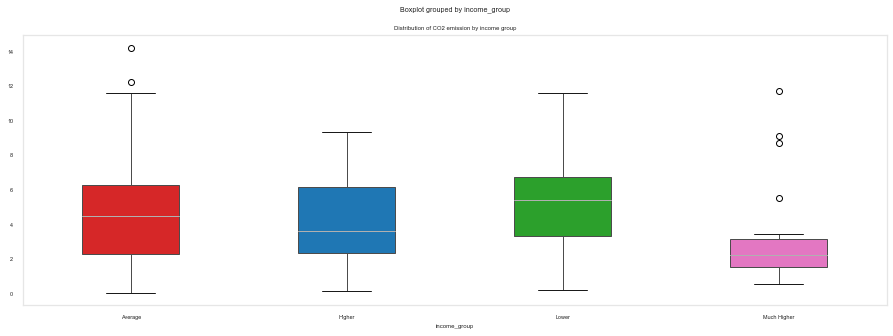

In [26]:
ax = data.boxplot(column='CO2', by='income_group', patch_artist=True, figsize=(15,5))

ax.set_title('Distribution of CO2 emission by income group')

#To set the color for each income group
for i in range(4):
    box = ax.artists[i]
    box.set_facecolor(colors[i])
    
ax.grid(False)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('0.9')
ax.spines['left'].set_color('0.9')
ax.spines['top'].set_color('0.9')
ax.spines['right'].set_color('0.9')

For this figure I used the following principals for graphic excellence:

 * Present many numbers in a small space, i.e., efficiently.
 * Show uncertainty.
 * Encourage the eye to compare different pieces of data.
 * Present data in a way to facilitate comparisons.

#### Scatterplot

<AxesSubplot:xlabel='Density', ylabel='CO2'>

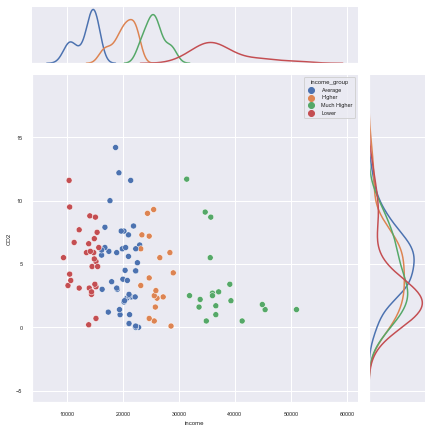

In [27]:
grid = sns.JointGrid(x='income', y='CO2', data=data)

g = grid.plot_joint(sns.scatterplot, hue='income_group', data=data)
sns.kdeplot(data.loc[data['income_group']=='Lower', 'income'], ax=g.ax_marg_x, legend=False)
sns.kdeplot(data.loc[data['income_group']=='Average', 'income'], ax=g.ax_marg_x, legend=False)
sns.kdeplot(data.loc[data['income_group']=='Higher', 'income'], ax=g.ax_marg_x, legend=False)
sns.kdeplot(data.loc[data['income_group']=='Much Higher', 'income'], ax=g.ax_marg_x, legend=False)
sns.kdeplot(data.loc[data['income_group']=='Lower', 'CO2'], ax=g.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(data.loc[data['income_group']=='Average', 'CO2'], ax=g.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(data.loc[data['income_group']=='Higher', 'CO2'], ax=g.ax_marg_y, vertical=True, legend=False)
sns.kdeplot(data.loc[data['income_group']=='Much Higher', 'CO2'], ax=g.ax_marg_y, vertical=True, legend=False)

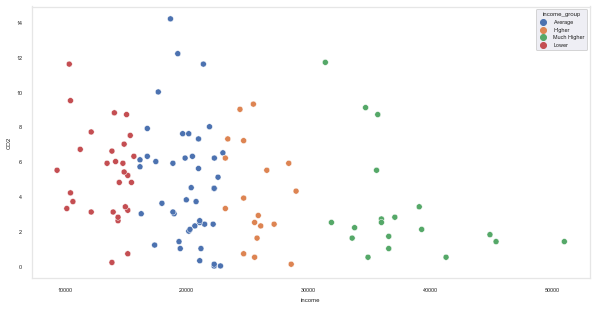

In [29]:
#Close up of the previous figure
f, ax = plt.subplots(1,1, figsize=(10, 5))
sns.scatterplot(x="income", y="CO2", hue="income_group", data=data, ax=ax);
ax.grid(False)
ax.set_facecolor('w')
ax.spines['bottom'].set_color('0.9')
ax.spines['left'].set_color('0.9')
ax.spines['top'].set_color('0.9')
ax.spines['right'].set_color('0.9')

For this figure I used the following principals for graphic excellence:

 * Present many numbers in a small space, i.e., efficiently.
 * Present data in a way to facilitate comparisons.
 * Make the dataset coherent.

#### Cloropleths

To display the CO2 emission and income per neighbourhood, I created two cloropleths.

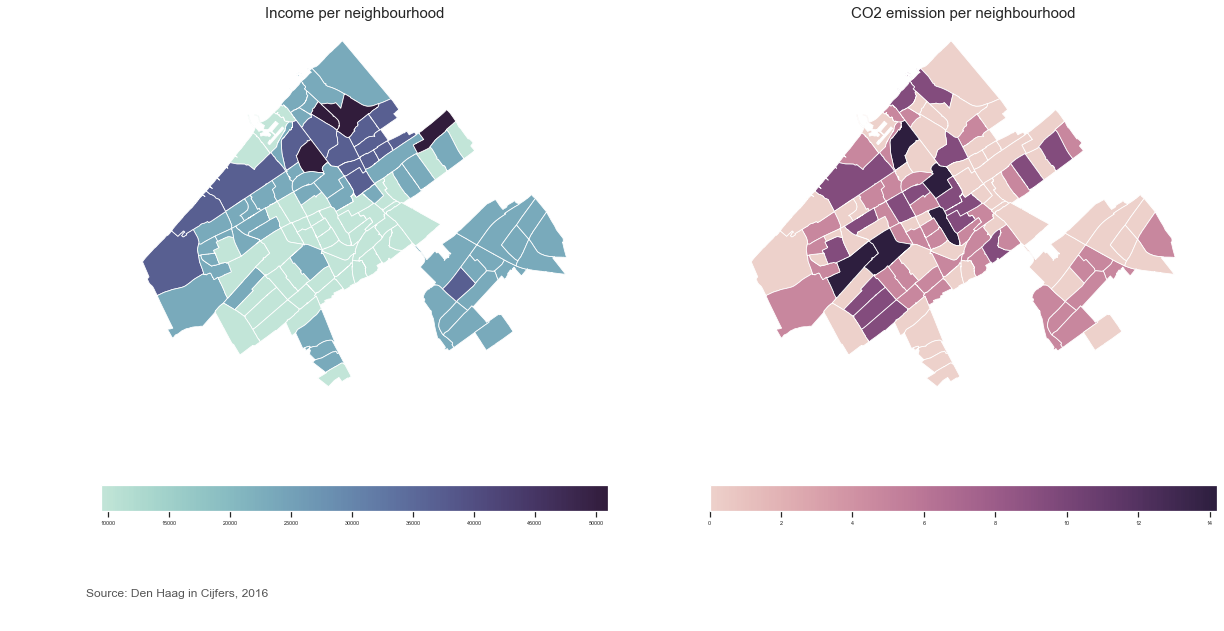

In [30]:
#Set the range for the choropleth
vmin0, vmax0 = 9400, 51000

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

data.plot(column='income', scheme='equal_interval', k=4, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), linewidth=0.8,  edgecolor='w', ax=ax[0])

#Add title to the map
ax[0].set_title('Income per neighbourhood', fontdict={'fontsize':15})

#Remove axes
ax[0].axis('off')

#Create an annotation for the data source
ax[0].annotate('Source: Den Haag in Cijfers, 2016', xy=(0.06, .06),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')


#Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), norm=plt.Normalize(vmin=vmin0, vmax=vmax0))
#Empty array for the data range
sm._A = []
#Add the colorbar to the figure
cbar = fig.colorbar(sm, orientation='horizontal', ax=ax[0])


vmin1, vmax1 = 0, 14.2

#Plot the other choropleth
data.plot(column='CO2', scheme='equal_interval', k=4, cmap=sns.cubehelix_palette(as_cmap=True), edgecolor='w', linewidth=0.8, ax=ax[1])


ax[1].set_title('CO2 emission per neighbourhood', fontdict={'fontsize':15})


ax[1].axis('off')


sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=plt.Normalize(vmin=vmin1, vmax=vmax1))

sm._A = []

cbar = fig.colorbar(sm, orientation='horizontal', ax=ax[1])

Next, I tried to find the cases that validate my hypothesis. For that, I looked for neighbourhoods with a **Higher** or **Much Higher income** as well as a **CO2 emission bigger than 7** (more or less the middle of the interval for the CO2 emissions).

In [31]:
filter_data1 = data[(data.income_group == 'Much Higher') & (data.CO2 > 7)]
filter_data1.head()

,geometry,CO2,income,income_group
neigb,,,,
46 Archipelbuurt,"POLYGON ((4.30625 52.09663, 4.30628 52.09661, ...",8.7,35700.0,Much Higher
07 Statenkwartier,"POLYGON ((4.27823 52.10228, 4.27829 52.10222, ...",11.7,31400.0,Much Higher
09 Vogelwijk,"POLYGON ((4.26475 52.09163, 4.26489 52.09151, ...",9.1,34700.0,Much Higher


In [32]:
filter_data2 = data[(data.income_group == 'Higher') & (data.CO2 > 7)]
filter_data2.head()

,geometry,CO2,income,income_group
neigb,,,,
71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.0,Higher
03 Scheveningen Badplaats,"POLYGON ((4.28401 52.11169, 4.28384 52.11158, ...",7.3,23400.0,Higher
53 Vruchtenbuurt,"POLYGON ((4.26183 52.07348, 4.26210 52.07295, ...",7.2,24700.0,Higher
66 Bezuidenhout-Oost,"POLYGON ((4.34235 52.09126, 4.34241 52.09121, ...",9.0,24400.0,Higher


Then, I defined a list to save the neighbourhoods that could be of interest.

In [36]:
interesting_neigbs=[]
interesting_neigbs.append(filter_data1.index)
interesting_neigbs.append(filter_data2.index)
interesting_neigbs

[Index(['46 Archipelbuurt', '07 Statenkwartier', '09 Vogelwijk'], dtype='object', name='neigb'),
 Index(['71 Belgisch Park', '03 Scheveningen Badplaats', '53 Vruchtenbuurt',
        '66 Bezuidenhout-Oost'],
       dtype='object', name='neigb')]

Then, I plotted the cloropleth displaying the CO2 emission per neighbourhood together with the bike lanes network to test if the CO2 emission could be related to it.

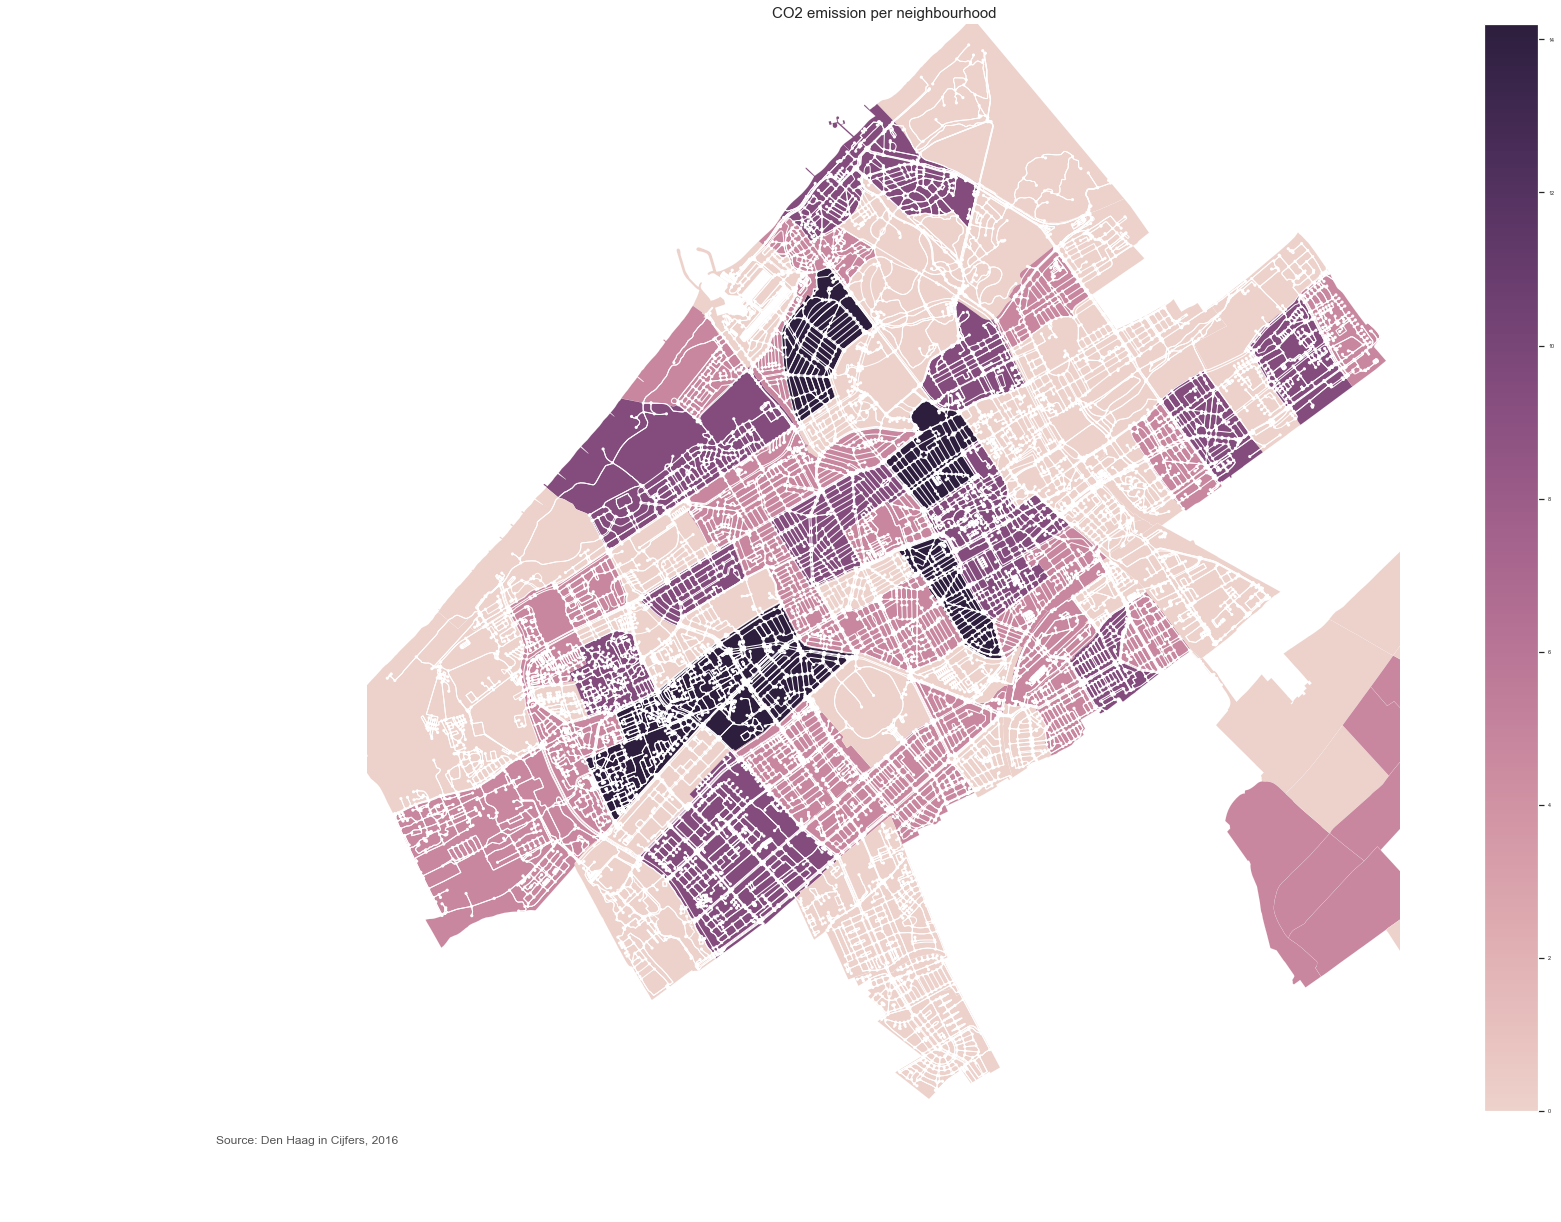

(<Figure size 2160x1440 with 2 Axes>,
 <AxesSubplot:title={'center':'CO2 emission per neighbourhood'}>)

In [37]:
variable = 'CO2'
# set the range for the choropleth
vmin, vmax = 0, 14.2


fig, ax = plt.subplots(1, figsize=(30, 20))

data.plot(column=variable, scheme='equal_interval', k=4, cmap=sns.cubehelix_palette(as_cmap=True), alpha=1, edgecolor='w', linewidth=0.1, ax=ax) #legend=True?


ax.set_title('CO2 emission per neighbourhood', fontdict={'fontsize':15})


ax.axis('off')



ax.annotate('Source: Den Haag in Cijfers, 2016', xy=(0.1, .06),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')



sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=plt.Normalize(vmin=vmin, vmax=vmax))

sm._A = []

cbar = fig.colorbar(sm)

#To plot the graph with bike network
G = ox.graph_from_place('The Hague, The Netherlands', network_type='bike')
ox.plot_graph(G, node_size=10, edge_color='w', ax=ax)

To measure the amount of bike lanes per neighbourhood, I used the *osmnx* `basic_stats` function in order to get their length.

In [38]:
polygon = data['geometry']
stats = []

#To create a list with a dictionary with the stats for each polygon
for pol in polygon:
    stats.append(ox.basic_stats(ox.graph_from_polygon(pol, network_type ='bike')))

In [39]:
length=[]

#To get a list with the bike lane length for each polygon
for i in range(len(polygon)):
    length = length + [stats[i]['street_length_total']]

After creating a list with the bike lanes length for each neighbourhood, I added it to the dataset.

In [40]:
#To add the length list to the dataset
data['bike_lanes_length'] = length
data.head()

,geometry,CO2,income,income_group,bike_lanes_length
neigb,,,,,
70 Oostduinen,"POLYGON ((4.30290 52.12832, 4.30298 52.12827, ...",0.0,22284.90566,Average,8762.422
71 Belgisch Park,"POLYGON ((4.28056 52.11706, 4.28053 52.11706, ...",9.3,25500.00000,Higher,23756.118
73 Westbroekpark,"POLYGON ((4.29171 52.10745, 4.29181 52.10739, ...",1.4,45400.00000,Much Higher,5977.102
74 Duttendel,"POLYGON ((4.32252 52.10768, 4.32252 52.10766, ...",1.8,44900.00000,Much Higher,20848.827
48 Nassaubuurt,"POLYGON ((4.31943 52.09247, 4.31943 52.09247, ...",2.1,39300.00000,Much Higher,5484.214


I tried to get a sense if this variable would be related to the CO2 emission by ordering the data and then plot part of the cloropleth together with the bike network corresponding to certain polygons. 

In [42]:
#Return the first 5 rows ordered by columns in ascending order
smaller_bk=data.nsmallest(5, 'bike_lanes_length')
smaller_bk

,geometry,CO2,income,income_group,bike_lanes_length
neigb,,,,,
109 Tedingerbroek,"POLYGON ((4.37090 52.05809, 4.37371 52.05609, ...",4.459091,22284.90566,Average,56.473
62 Rivierenbuurt-Zuid,"POLYGON ((4.33384 52.07499, 4.33318 52.07469, ...",0.700000,15200.00000,Lower,1236.080
101 Erasmus Veld,"POLYGON ((4.29095 52.04157, 4.29095 52.04157, ...",1.000000,19500.00000,Average,4170.589
72 Rijslag,"POLYGON ((4.29008 52.10836, 4.29004 52.10833, ...",2.300000,26100.00000,Higher,4343.720
78 Arendsdorp,"POLYGON ((4.32329 52.09921, 4.32388 52.09870, ...",1.700000,36600.00000,Much Higher,4415.949


In [43]:
#Return the first 5 rows ordered by columns in descending order
larger_bk=data.nlargest(5, 'bike_lanes_length')
larger_bk

,geometry,CO2,income,income_group,bike_lanes_length
neigb,,,,,
97 Kraayenstein & Vroondaal,"POLYGON ((4.23657 52.05055, 4.23661 52.05051, ...",5.1,22600.00000,Average,53686.940
86 Houtwijk,"POLYGON ((4.25924 52.06264, 4.25924 52.06264, ...",12.2,19300.00000,Average,41407.263
84 Leyenburg,"POLYGON ((4.27018 52.06684, 4.27023 52.06678, ...",14.2,18700.00000,Average,37812.639
117 De Rivieren,"POLYGON ((4.39709 52.07476, 4.39778 52.07496, ...",0.0,22284.90566,Average,34073.842
98 Dreven en Gaarden,"POLYGON ((4.28002 52.04023, 4.27973 52.04008, ...",8.8,14100.00000,Lower,30187.911


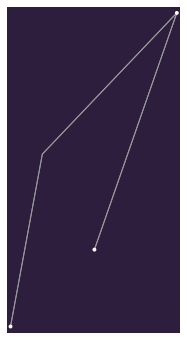

Index(['109 Tedingerbroek'], dtype='object', name='neigb')


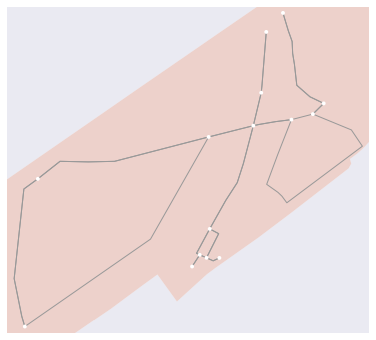

Index(['62 Rivierenbuurt-Zuid'], dtype='object', name='neigb')


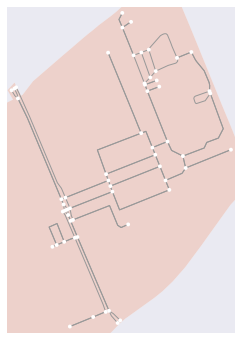

Index(['101 Erasmus Veld'], dtype='object', name='neigb')


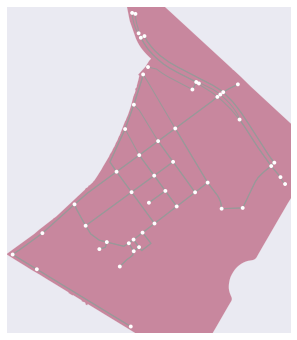

Index(['72 Rijslag'], dtype='object', name='neigb')


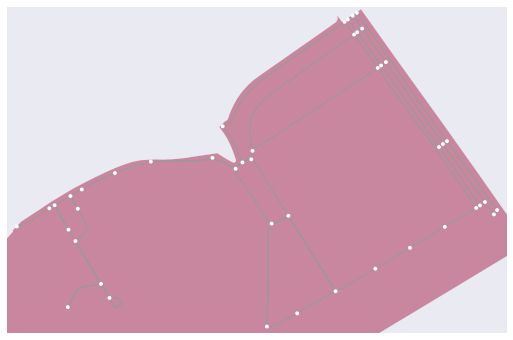

Index(['78 Arendsdorp'], dtype='object', name='neigb')


In [44]:
#To plot the geometries with the smaller length of bike lanes 
polygon=smaller_bk['geometry']
for pol in polygon:
    fig, ax = plt.subplots(1, figsize=(10, 6))
    smaller_bk.plot(column='CO2', scheme='equal_interval', k=4, cmap=sns.cubehelix_palette(as_cmap=True), alpha=1, edgecolor='w', linewidth=0.1, ax=ax) 
    G = ox.graph_from_polygon(pol, network_type ='bike')
    ox.plot_graph(G, ax=ax)
    print(smaller_bk.index[smaller_bk.geometry == pol])

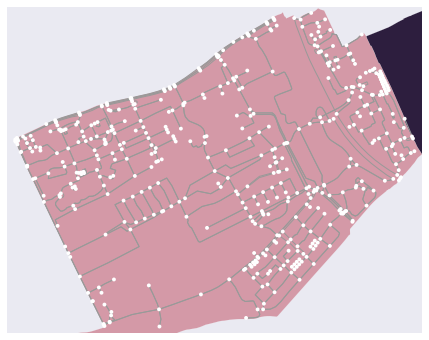

Index(['97 Kraayenstein & Vroondaal'], dtype='object', name='neigb')


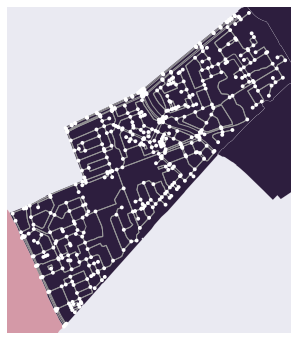

Index(['86 Houtwijk'], dtype='object', name='neigb')


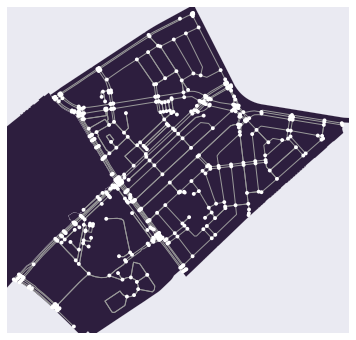

Index(['84 Leyenburg'], dtype='object', name='neigb')


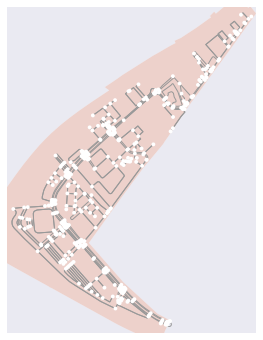

Index(['117 De Rivieren'], dtype='object', name='neigb')


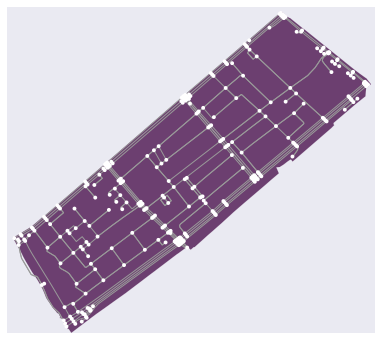

Index(['98 Dreven en Gaarden'], dtype='object', name='neigb')


In [45]:
#To plot the geometries with the bigger length of bike lanes 
polygon=larger_bk['geometry']
for pol in polygon:
    fig, ax = plt.subplots(1, figsize=(10, 6))
    larger_bk.plot(column='CO2', scheme='equal_interval', k=5, cmap=sns.cubehelix_palette(as_cmap=True), alpha=1, edgecolor='w', linewidth=0.1, ax=ax) 
    G = ox.graph_from_polygon(pol, network_type ='bike')
    ox.plot_graph(G, ax=ax)
    print(larger_bk.index[larger_bk.geometry == pol])

Looking at the geometries plotted above I have not only cases that agree with my hypothesis but also cases that refute it. Taking this into account, I would select neighbourhoods that fit into the both cases, for further analysis and to understand why that is.

Analysing each case:

For the neighbourhoods with the smaller length of bike lanes:
 * `109 Tedingerbroek` - high CO2 emission and average income -> somewhat in accordance with my hypotesis.
 
 * `62 Rivierenbuurt-Zuid` - low CO2 emission and low income (even with the smaller amount of bike lanes -> in accordance with my hypotesis(except for the bike lanes parameter).
 
 * `101 Erasmus Veld`- low CO2 emission and average income
 
 * `72 Rijslag` - considerable CO2 emission and high income -> in accordance with my hypotesis (except for the bike lanes parameter).
 
 * `78 Arendsdorp` - considerable CO2 emission and much higher income -> in accordance with my hypotesis (except for the bike lanes parameter).
 

For the neighbourhoods with the smaller length of bike lanes:
 * `97 Kraayenstein & Vroondaal` - low/medium CO2 emission and average income -> somewhat in accordance with my hypotesis.
 
 * `86 Houtwijk` - high CO2 emission and average income -> not valid for the bike lane parameter.
 
 * `84 Leyenburg` - high CO2 emission and average income -> not valid for the bike lane parameter.
 
 * `117 De Rivieren` - low CO2 emission and average income -> in accordance with my hypotesis.
 
 * `98 Dreven en Gaarden` - considerable CO2 emission and low income -> refutes my hypothesis.


In [51]:
interesting_neigbs

[Index(['46 Archipelbuurt', '07 Statenkwartier', '09 Vogelwijk'], dtype='object', name='neigb'),
 Index(['71 Belgisch Park', '03 Scheveningen Badplaats', '53 Vruchtenbuurt',
        '66 Bezuidenhout-Oost'],
       dtype='object', name='neigb')]

I could only choose to analyse the neighbourhoods present in **interesting_neigbs** list (the ones that support my first hypothesis), however I would also want to analyse the cases that go against it and against the hypothesis complemented with the bike lane length, in order to understand what other factors are behind it.

Taking that into account I would choose the following neighbourhoods to do a further analysis:
* `07 Statenkwartier` (from **interesting_neigbs** list, Much Higher Income)
* `71 Belgisch Park` (from **interesting_neigbs** list, Higher Income)
* `62 Rivierenbuurt-Zuid` (in accordance with my hypotesis, except for the bike lanes parameter)
* `117 De Rivieren` (in accordance with my hypothesis)
* `98 Dreven en Gaarden` (refutes my hypothesis)

#### Global Spatial autocorrelation - Moran's I

I decided to proceed with an analysis to the global spacial autocorrelation.

In [46]:
# Create the spatial weights matrix
w = weights.Queen.from_dataframe(data)

In [47]:
mi = esda.Moran(data['CO2'], w)

To retrieve the value of the statistic:

In [48]:
mi.I

0.11447481515470756

In [49]:
mi.p_sim

0.033

By standard terms, 3.3% would be considered statistically significant, which means that, if we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran's I statistic for each of those maps, 3.3% of them would display a larger (absolute) value than the one we obtain from the real data, and the other 96.7% of the random maps would receive a smaller (absolute) value of Moran's I. Since the value of Moran's I can be interpreted as the slope of the Moran Plot, in this case, the particular spatial arrangement of values for the CO2 emission are more or less concentrated than if the values had been allocated following a completely spatially random process - that is why we have a statistical significance.

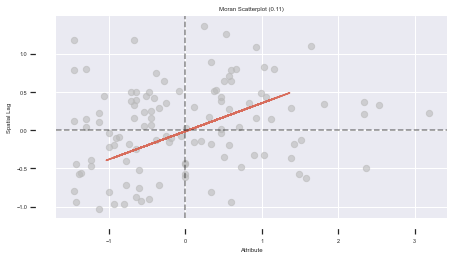

In [50]:
moran_scatterplot(mi);

Looking at the global autocorrelation analysis, the observations do seem to be positively correlated over space. Even though I was expecting a more structured pathern. I even consider if the CO2 emission shows a pattern over space at all and if it's not a random one. I would proceed with a local spacial autocorrelation.